In [45]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random
from scipy import stats

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

### Load previous saved corpus file

In [2]:
data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl') #load data for tf-idf
data.columns

Index(['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year',
       'notes_split', 'len_notes', 'notes_clean', 'len_clean',
       'spacy_notes_clean', 'lss_notes', 'len_lss', 'lss_corpus',
       'spacy_lss_corpus'],
      dtype='object')

In [3]:
# os.chdir("C:\\Users\\Insight1\\Anaconda3")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (data['len_lss']<=2000) & (data['len_lss']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_tfidf = data[filt][['age', 'le','le_year','lss_notes','lss_corpus']]

corpus = data_tfidf['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf data most frequent 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

### Prepare data for model

In [4]:
X = corpus_tfidf.toarray()
x_age = np.expand_dims(data_tfidf['age'].to_numpy(), axis = 1)

# X y from tf-idf for Model
X = np.hstack((x_age, X))
y = data_tfidf['le'].to_numpy() 

### Multilayer Perceptron Model

In [5]:
print(X.shape,y.shape)

(53020, 4001) (53020,)


In [6]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

# # normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_val[:, 0] = (X_val[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.models.Sequential()

model.add(keras.Input(shape=4001,))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'normal'))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = 1))
model.summary()

model.compile(optimizer= 'adam',loss = 'mean_squared_error')

checkpoint_filepath = '/log'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=10000, epochs=1000, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

print(history.history.keys())
model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

from sklearn.metrics import mean_absolute_error
abs_er = mean_absolute_error(y_test, y_test_nn)
print(abs_er)

from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_train_nn)
rsq_val = r2_score(y_val, y_val_nn)
rsq_test = r2_score(y_test, y_test_nn)

print(rsq_train, rsq_val, rsq_test)
# model prediction from medical notes without age 
# 100 epoches: abs_er= 19.991914022416207; rsq_test =0.6311475230416835; rsq_train = 0.9392278263642062 
# 20.781554059329675
# 0.6444936458044239 0.5632780303898981 0.5536371000303386

#3000 epoch (512/256/512) abs=23.203737412144314  r2 = 0.768495009799099  0.5852656900697112 0.5530109538595611
#3000 epoch (512/0.3,256/0.3, 512)abs=20.688904906315482 r2 =0.9325278290184188 0.6484640725710789 0.61039924081627


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               1024512   
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

37114/37114 [==============================] - 1s 32us/sample - loss: 6880.6189 - val_loss: 8558.6719
Epoch 60/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 6823.5517 - val_loss: 8389.1211
Epoch 61/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6758.6665 - val_loss: 8252.6299
Epoch 62/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6694.8403 - val_loss: 8112.1094
Epoch 63/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6626.7271 - val_loss: 7947.9561
Epoch 64/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6563.0102 - val_loss: 7819.7246
Epoch 65/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6499.2812 - val_loss: 7658.6865
Epoch 66/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6431.6504 - val_loss: 7547.8145
Epoch 67/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 63

37114/37114 [==============================] - 1s 34us/sample - loss: 1854.7274 - val_loss: 1955.0422
Epoch 130/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1808.9946 - val_loss: 1911.3129
Epoch 131/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1756.5066 - val_loss: 1839.4062
Epoch 132/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1698.9134 - val_loss: 1801.8340
Epoch 133/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1648.4792 - val_loss: 1752.8765
Epoch 134/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1591.2123 - val_loss: 1699.6094
Epoch 135/1000
37114/37114 [==============================] - 1s 34us/sample - loss: 1544.7279 - val_loss: 1667.5509
Epoch 136/1000
37114/37114 [==============================] - 1s 34us/sample - loss: 1491.2164 - val_loss: 1622.5674
Epoch 137/1000
37114/37114 [==============================] - 1s 32us/sample - 

37114/37114 [==============================] - 1s 32us/sample - loss: 159.6747 - val_loss: 259.6058
Epoch 201/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 154.3829 - val_loss: 250.1648
Epoch 202/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 152.6957 - val_loss: 245.3221
Epoch 203/1000
37114/37114 [==============================] - 1s 35us/sample - loss: 147.5407 - val_loss: 242.6237
Epoch 204/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 148.6423 - val_loss: 238.0865
Epoch 205/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 143.3698 - val_loss: 244.6043
Epoch 206/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 142.2264 - val_loss: 239.1415
Epoch 207/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 137.9966 - val_loss: 230.2389
Epoch 208/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 136.2481 -

37114/37114 [==============================] - 1s 15us/sample - loss: 92.9026 - val_loss: 187.7132
Epoch 272/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 91.7996 - val_loss: 188.3508
Epoch 273/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 91.9602 - val_loss: 187.5847
Epoch 274/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.9603 - val_loss: 187.3896
Epoch 275/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.3520 - val_loss: 187.7443
Epoch 276/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.6726 - val_loss: 187.6071
Epoch 277/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.0087 - val_loss: 188.0249
Epoch 278/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 91.8696 - val_loss: 187.6245
Epoch 279/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 92.7484 - val_loss

Epoch 343/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.3915 - val_loss: 183.4493
Epoch 344/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.7354 - val_loss: 183.9686
Epoch 345/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 83.3901 - val_loss: 184.0126
Epoch 346/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.3252 - val_loss: 185.3716
Epoch 347/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 83.3753 - val_loss: 185.0352
Epoch 348/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.0350 - val_loss: 184.9947
Epoch 349/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.6701 - val_loss: 184.8380
Epoch 350/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.1371 - val_loss: 184.5505
Epoch 351/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.

Epoch 415/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.9749 - val_loss: 182.2324
Epoch 416/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 72.7842 - val_loss: 181.6918
Epoch 417/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 73.7012 - val_loss: 181.5156
Epoch 418/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.8794 - val_loss: 181.8705
Epoch 419/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 73.2064 - val_loss: 181.0554
Epoch 420/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.5256 - val_loss: 181.8078
Epoch 421/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.9406 - val_loss: 182.9304
Epoch 422/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.7010 - val_loss: 182.7885
Epoch 423/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.

Epoch 487/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.0540 - val_loss: 182.8091
Epoch 488/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 67.2204 - val_loss: 182.0597
Epoch 489/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.1018 - val_loss: 181.9340
Epoch 490/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.2607 - val_loss: 181.2188
Epoch 491/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.0265 - val_loss: 181.5209
Epoch 492/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.6126 - val_loss: 181.6823
Epoch 493/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.5295 - val_loss: 181.9958
Epoch 494/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 64.7302 - val_loss: 182.1776
Epoch 495/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 65.

Epoch 559/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.3736 - val_loss: 179.6750
Epoch 560/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.7459 - val_loss: 179.8743
Epoch 561/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.7883 - val_loss: 179.8216
Epoch 562/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.4633 - val_loss: 180.0305
Epoch 563/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.2704 - val_loss: 180.0213
Epoch 564/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.7874 - val_loss: 179.7442
Epoch 565/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 59.9882 - val_loss: 180.3251
Epoch 566/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.9940 - val_loss: 180.8217
Epoch 567/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.

Epoch 631/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.2198 - val_loss: 180.2261
Epoch 632/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.4585 - val_loss: 180.6243
Epoch 633/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.5049 - val_loss: 180.3394
Epoch 634/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.8241 - val_loss: 179.8415
Epoch 635/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 57.2942 - val_loss: 179.4021
Epoch 636/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.1963 - val_loss: 179.4571
Epoch 637/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.3832 - val_loss: 179.6265
Epoch 638/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 56.3721 - val_loss: 180.0831
Epoch 639/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.

Epoch 703/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5312 - val_loss: 179.4947
Epoch 704/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.5299 - val_loss: 179.3540
Epoch 705/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.8058 - val_loss: 178.9857
Epoch 706/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.6809 - val_loss: 179.0856
Epoch 707/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.1850 - val_loss: 178.7441
Epoch 708/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 54.2629 - val_loss: 179.6893
Epoch 709/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.8842 - val_loss: 180.0870
Epoch 710/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.7489 - val_loss: 178.4193
Epoch 711/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.

Epoch 775/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.3465 - val_loss: 180.1278
Epoch 776/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.7814 - val_loss: 179.8057
Epoch 777/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.4115 - val_loss: 179.6701
Epoch 778/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 53.9714 - val_loss: 179.9357
Epoch 779/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.8646 - val_loss: 179.9459
Epoch 780/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5531 - val_loss: 180.3880
Epoch 781/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.9841 - val_loss: 180.8550
Epoch 782/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.6119 - val_loss: 180.9350
Epoch 783/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.

Epoch 847/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.6025 - val_loss: 179.7649
Epoch 848/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1813 - val_loss: 179.4338
Epoch 849/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.3293 - val_loss: 180.1174
Epoch 850/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5258 - val_loss: 180.3163
Epoch 851/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.2984 - val_loss: 180.2416
Epoch 852/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5967 - val_loss: 179.7869
Epoch 853/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2975 - val_loss: 180.0338
Epoch 854/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2325 - val_loss: 180.2663
Epoch 855/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.

37114/37114 [==============================] - 1s 15us/sample - loss: 51.5962 - val_loss: 179.7924
Epoch 919/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5117 - val_loss: 180.3136
Epoch 920/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.1448 - val_loss: 180.3040
Epoch 921/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.7459 - val_loss: 179.4955
Epoch 922/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.6216 - val_loss: 179.6445
Epoch 923/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.8731 - val_loss: 179.5034
Epoch 924/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5418 - val_loss: 179.8615
Epoch 925/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 51.3284 - val_loss: 179.5066
Epoch 926/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.8854 - val_loss

Epoch 990/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.4428 - val_loss: 178.9530
Epoch 991/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 51.5757 - val_loss: 181.0711
Epoch 992/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5330 - val_loss: 179.9639
Epoch 993/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.4369 - val_loss: 178.8802
Epoch 994/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.5222 - val_loss: 178.3025
Epoch 995/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 50.9331 - val_loss: 178.5336
Epoch 996/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.5638 - val_loss: 179.7990
Epoch 997/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.5424 - val_loss: 179.5117
Epoch 998/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.

In [ ]:
# model prediction with medical notes and age
#nn2  mae = 7.405138590254005  r2 = 0.9984009999191925 0.9192866197881329 0.9276604851173823
#nn3  mae = 8.015569902644522  r2 = 0.9954704425552736 0.9148370915600145 0.9191962513274201
#nn4  mae = 7.577290564651806  r2 = 0.9973174955792151 0.9206192821982901 0.924039436369253
#nn5  mae = 9.251247986471009  r2 = 0.9840954167602272 0.9045084253849334 0.9075974502547768

In [ ]:
print(history.history.keys())
model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

(array([-20., -10.,   0.,  10.,  20.,  30.,  40.]),
 <a list of 7 Text yticklabel objects>)

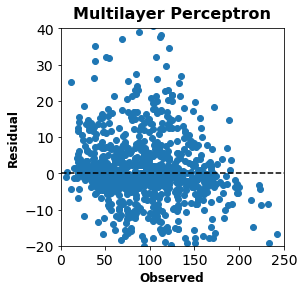

In [25]:
# residual = np.absolute(np.squeeze(y_test_nn) - y_test)
residual = np.squeeze(y_test_nn) - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[1000:2000], residual[1000:2000])
# plt.plot(range(300), range(300), '-k')
plt.axhline(y=0, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Multilayer Perceptron', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.show()
# plt.savefig('neural network Residual.png', dpi =400)

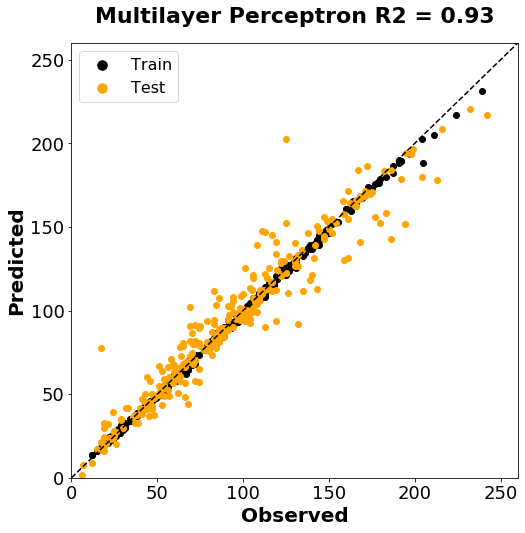

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1300], y_train_nn[1000:1300], label = 'Train', color='black')
plt.scatter(y_test[1000:1300], y_test_nn[1000:1300], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Multilayer Perceptron R2 = 0.93', fontsize =22, fontweight = 'bold', pad=20)
plt.xlabel('Observed',fontsize =20, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =20, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
# (prop = {'size': 20})
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
plt.show()
# plt.savefig('Multilayer Perceptron predicted vs observed.png', dpi = 400)